In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [54]:
#импортируем нужные библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import optuna
import category_encoders as ce
from numpy import absolute
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer

In [55]:
try:
    data_train = pd.read_csv('train.csv') #откроем датасеты
    data_test = pd.read_csv('test.csv')
except:
    data_train = pd.read_csv('/kaggle/input/used-cars-price-prediction/train.csv') #откроем датасеты в kaggle
    data_test = pd.read_csv('/kaggle/input/used-cars-price-prediction/test.csv')

In [56]:
object_columns = data_train.dtypes[data_train.dtypes == "object"].index.values.tolist() #для дальнейшней работы сразу определим колонки с категориальными признаками
print(object_columns)

['make', 'model', 'trim', 'body', 'transmission', 'vin', 'state', 'color', 'interior', 'seller', 'saledate']


In [57]:
numeric_columns = data_train.dtypes[data_train.dtypes == 'int64'].index.values.tolist() + data_train.dtypes[data_train.dtypes == 'float64'].index.values.tolist() #определим колонки с количественными данными
numeric_columns

['year', 'sellingprice', 'condition', 'odometer']

In [58]:
#воспользуемся функцией для вывода основной информации по датасету
def get_info(data):
    print("\nShape:\n")
    display(data.shape)
    print("\nInfo:\n")
    data.info()
    print("\nHead:\n")
    display(data.head())
    print("\nDuplicated:\n")
    display(data.duplicated().sum())
    for column in (object_columns + numeric_columns):
        try:
            print('\nValue counts in ' + column + ':' + '\n')
            display(data[column].value_counts())
            print('Количество уникальных значений:', len(data[column].unique()), '\n')
            if column in object_columns:
                data[column] = data[column].str.strip() #сразу уберем лишние пробелы, если они есть
                display(data[column].value_counts())
                print('Количество уникальных значений после удаления пробелов:', len(data[column].unique()), '\n')
        except:
            ('No data')
            pass

In [59]:
get_info(data_train)


Shape:



(440236, 15)


Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   state         440236 non-null  object 
 8   condition     430831 non-null  float64
 9   odometer      440167 non-null  float64
 10  color         439650 non-null  object 
 11  interior      439650 non-null  object 
 12  seller        440236 non-null  object 
 13  sellingprice  440236 non-null  int64  
 14  saledate      440236 non-null  object 
dtypes: float64(2), int64(2), object(11)
memory usage: 50.4+ MB

Head:



,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)
3,2003,HUMMER,H2,Base,suv,automatic,5grgn23u93h101360,tx,2.8,131301.0,gold,beige,wichita falls ford lin inc,13300,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
4,2007,Ford,Fusion,SEL,Sedan,automatic,3fahp08z17r268380,md,2.0,127709.0,black,black,purple heart,1300,Tue Feb 03 2015 04:00:00 GMT-0800 (PST)



Duplicated:



0


Value counts in make:



Ford         73708
Chevrolet    47492
Nissan       42811
Toyota       31630
Dodge        24103
             ...  
Daewoo           1
dodge tk         1
mazda tk         1
dot              1
airstream        1
Name: make, Length: 92, dtype: int64

Количество уникальных значений: 93 



Ford         73708
Chevrolet    47492
Nissan       42811
Toyota       31630
Dodge        24103
             ...  
Daewoo           1
dodge tk         1
mazda tk         1
dot              1
airstream        1
Name: make, Length: 92, dtype: int64

Количество уникальных значений после удаления пробелов: 93 


Value counts in model:



Altima           15454
F-150            11408
Fusion           10244
Camry             9996
Escape            9419
                 ...  
Civic del Sol        1
Tempo                1
Regency              1
8 Series             1
g500                 1
Name: model, Length: 959, dtype: int64

Количество уникальных значений: 960 



Altima           15454
F-150            11408
Fusion           10244
Camry             9996
Escape            9419
                 ...  
Civic del Sol        1
Tempo                1
Regency              1
8 Series             1
g500                 1
Name: model, Length: 959, dtype: int64

Количество уникальных значений после удаления пробелов: 960 


Value counts in trim:



Base                        43853
SE                          34465
LX                          16490
Limited                     14514
LT                          13374
                            ...  
2.3 Premium                     1
GLS V6 4Motion                  1
2500 High Ceiling 118 WB        1
Z71 SL                          1
4x4 v6 xlt sport                1
Name: trim, Length: 1922, dtype: int64

Количество уникальных значений: 1923 



Base                43853
SE                  34465
LX                  16490
Limited             14524
LT                  13374
                    ...  
awd limited             1
fwd 4c base             1
4x2 ex xl               1
Limited (1994.5)        1
4x4 v6 xlt sport        1
Name: trim, Length: 1913, dtype: int64

Количество уникальных значений после удаления пробелов: 1914 


Value counts in body:



Sedan              157639
SUV                 93633
sedan               33222
suv                 19409
Hatchback           16893
                    ...  
q60 convertible         2
Ram Van                 1
g37 coupe               1
cab plus 4              1
CTS-V Wagon             1
Name: body, Length: 85, dtype: int64

Количество уникальных значений: 86 



Sedan              157639
SUV                 93633
sedan               33222
suv                 19409
Hatchback           16893
                    ...  
q60 convertible         2
Ram Van                 1
g37 coupe               1
cab plus 4              1
CTS-V Wagon             1
Name: body, Length: 85, dtype: int64

Количество уникальных значений после удаления пробелов: 86 


Value counts in transmission:



automatic    375061
manual        13714
Name: transmission, dtype: int64

Количество уникальных значений: 3 



automatic    375061
manual        13714
Name: transmission, dtype: int64

Количество уникальных значений после удаления пробелов: 3 


Value counts in vin:



2fmdk3jc4bba41556    1
1g1pg5sb2d7145116    1
3vwdx7aj9cm313804    1
4t1bf1fk8eu812681    1
wba3t3c51ep737328    1
                    ..
ys3eh59g463523257    1
3gcec23099g216975    1
1lnhl9ek9dg616880    1
5n1ar1nb6bc617359    1
jn8as5mt9dw038107    1
Name: vin, Length: 440236, dtype: int64

Количество уникальных значений: 440236 



2fmdk3jc4bba41556    1
1g1pg5sb2d7145116    1
3vwdx7aj9cm313804    1
4t1bf1fk8eu812681    1
wba3t3c51ep737328    1
                    ..
ys3eh59g463523257    1
3gcec23099g216975    1
1lnhl9ek9dg616880    1
5n1ar1nb6bc617359    1
jn8as5mt9dw038107    1
Name: vin, Length: 440236, dtype: int64

Количество уникальных значений после удаления пробелов: 440236 


Value counts in state:



fl    65618
ca    57407
pa    42462
tx    36104
ga    27141
nj    22102
il    18651
nc    17051
oh    16959
tn    16156
mo    12563
mi    12393
nv     9830
va     9444
md     8858
wi     7866
mn     7436
az     6903
co     6118
wa     5883
ma     5323
ny     4533
in     3453
sc     3315
ne     3213
on     2722
pr     2162
la     1741
ms     1468
ut     1451
qc     1000
hi      992
or      928
ab      729
nm      130
ok       60
ns       52
al       19
Name: state, dtype: int64

Количество уникальных значений: 38 



fl    65618
ca    57407
pa    42462
tx    36104
ga    27141
nj    22102
il    18651
nc    17051
oh    16959
tn    16156
mo    12563
mi    12393
nv     9830
va     9444
md     8858
wi     7866
mn     7436
az     6903
co     6118
wa     5883
ma     5323
ny     4533
in     3453
sc     3315
ne     3213
on     2722
pr     2162
la     1741
ms     1468
ut     1451
qc     1000
hi      992
or      928
ab      729
nm      130
ok       60
ns       52
al       19
Name: state, dtype: int64

Количество уникальных значений после удаления пробелов: 38 


Value counts in color:



black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            19520
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off-white     1143
yellow         979
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

Количество уникальных значений: 21 



black        87115
white        84149
silver       65667
gray         65284
blue         40237
red          34514
—            19520
green         8975
gold          8934
beige         7257
burgundy      7059
brown         5320
orange        1629
purple        1250
off-white     1143
yellow         979
charcoal       389
turquoise      183
pink            32
lime            14
Name: color, dtype: int64

Количество уникальных значений после удаления пробелов: 21 


Value counts in interior:



black        192442
gray         140843
beige         46878
tan           34709
—             13563
brown          6818
red            1070
blue            885
silver          844
off-white       373
purple          276
gold            256
white           215
green           198
burgundy        155
orange          109
yellow           16
Name: interior, dtype: int64

Количество уникальных значений: 18 



black        192442
gray         140843
beige         46878
tan           34709
—             13563
brown          6818
red            1070
blue            885
silver          844
off-white       373
purple          276
gold            256
white           215
green           198
burgundy        155
orange          109
yellow           16
Name: interior, dtype: int64

Количество уникальных значений после удаления пробелов: 18 


Value counts in seller:



nissan-infiniti lt                15823
ford motor credit company,llc     15276
the hertz corporation             14692
santander consumer                12230
avis corporation                  10098
                                  ...  
bay shore motors                      1
thrifty rent a car systems inc        1
volvo of wichita                      1
wright way hyundai                    1
studio city auto group                1
Name: seller, Length: 13025, dtype: int64

Количество уникальных значений: 13025 



nissan-infiniti lt                15823
ford motor credit company,llc     15276
the hertz corporation             14692
santander consumer                12230
avis corporation                  10098
                                  ...  
bay shore motors                      1
thrifty rent a car systems inc        1
volvo of wichita                      1
wright way hyundai                    1
studio city auto group                1
Name: seller, Length: 13025, dtype: int64

Количество уникальных значений после удаления пробелов: 13025 


Value counts in saledate:



Tue Feb 10 2015 01:30:00 GMT-0800 (PST)    4209
Tue Jan 27 2015 01:30:00 GMT-0800 (PST)    3878
Tue Feb 17 2015 01:30:00 GMT-0800 (PST)    3862
Tue Jan 20 2015 01:30:00 GMT-0800 (PST)    3777
Tue Mar 03 2015 01:30:00 GMT-0800 (PST)    3633
                                           ... 
Wed Jan 07 2015 05:10:00 GMT-0800 (PST)       1
Thu Jun 25 2015 03:35:00 GMT-0700 (PDT)       1
Wed Jun 17 2015 06:15:00 GMT-0700 (PDT)       1
Wed Apr 01 2015 09:31:00 GMT-0700 (PDT)       1
Wed May 20 2015 01:30:00 GMT-0700 (PDT)       1
Name: saledate, Length: 3597, dtype: int64

Количество уникальных значений: 3597 



Tue Feb 10 2015 01:30:00 GMT-0800 (PST)    4209
Tue Jan 27 2015 01:30:00 GMT-0800 (PST)    3878
Tue Feb 17 2015 01:30:00 GMT-0800 (PST)    3862
Tue Jan 20 2015 01:30:00 GMT-0800 (PST)    3777
Tue Mar 03 2015 01:30:00 GMT-0800 (PST)    3633
                                           ... 
Wed Jan 07 2015 05:10:00 GMT-0800 (PST)       1
Thu Jun 25 2015 03:35:00 GMT-0700 (PDT)       1
Wed Jun 17 2015 06:15:00 GMT-0700 (PDT)       1
Wed Apr 01 2015 09:31:00 GMT-0700 (PDT)       1
Wed May 20 2015 01:30:00 GMT-0700 (PDT)       1
Name: saledate, Length: 3597, dtype: int64

Количество уникальных значений после удаления пробелов: 3597 


Value counts in year:



2012    80625
2013    77566
2014    64225
2011    38115
2008    24646
2007    24152
2006    21118
2010    20647
2005    16794
2009    16064
2004    13658
2003    10512
2002     7726
2015     7462
2001     5147
2000     4161
1999     2658
1998     1747
1997     1224
1996      683
1995      567
1994      319
1993      168
1992      103
1991       56
1990       38
1989       15
1988       11
1985       10
1986        8
1987        5
1984        4
1983        1
1982        1
Name: year, dtype: int64

Количество уникальных значений: 34 


Value counts in sellingprice:



11000    3510
12000    3499
13000    3374
10000    3178
14000    3104
         ... 
57100       1
73100       1
41501       1
66700       1
2725        1
Name: sellingprice, Length: 1735, dtype: int64

Количество уникальных значений: 1735 


Value counts in condition:



1.9    33207
3.5    21016
3.7    20399
4.4    20027
4.3    19712
4.2    19345
3.6    18209
4.1    18108
2.0    16431
4.0    15797
3.9    15623
2.8    15012
2.9    14823
3.8    14785
3.4    13654
2.7    12837
4.9    10305
4.8    10040
2.5     9900
4.6     9897
4.5     9660
2.6     9403
4.7     9058
5.0     8862
3.3     8459
3.0     8451
3.2     7861
2.4     7378
2.1     7260
3.1     7258
2.3     6436
1.0     5855
2.2     4742
1.8      249
1.7      198
1.6      132
1.5      123
1.4      103
1.2       74
1.1       74
1.3       68
Name: condition, dtype: int64

Количество уникальных значений: 42 


Value counts in odometer:



1.0         1059
999999.0      55
10.0          23
21587.0       17
21310.0       17
            ... 
125152.0       1
73715.0        1
71041.0        1
197617.0       1
174269.0       1
Name: odometer, Length: 159364, dtype: int64

Количество уникальных значений: 159365 



In [60]:
get_info(data_test)


Shape:



(110060, 14)


Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110060 entries, 0 to 110059
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          110060 non-null  int64  
 1   make          107999 non-null  object 
 2   model         107981 non-null  object 
 3   trim          107946 non-null  object 
 4   body          107466 non-null  object 
 5   transmission  97048 non-null   object 
 6   vin           110060 non-null  object 
 7   state         110060 non-null  object 
 8   condition     107681 non-null  float64
 9   odometer      110041 non-null  float64
 10  color         109902 non-null  object 
 11  interior      109902 non-null  object 
 12  seller        110060 non-null  object 
 13  saledate      110060 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 11.8+ MB

Head:



,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)
3,2013,Chevrolet,Impala,LS Fleet,Sedan,automatic,2g1wf5e34d1160703,fl,2.3,57105.0,silver,black,onemain rem/auto club of miami inc dba north dad,Fri Mar 06 2015 02:00:00 GMT-0800 (PST)
4,2013,Nissan,Titan,SV,Crew Cab,automatic,1n6aa0ec3dn301209,tn,2.9,31083.0,black,black,nissan north america inc.,Wed Jun 03 2015 03:30:00 GMT-0700 (PDT)



Duplicated:



0


Value counts in make:



Ford            18384
Chevrolet       11739
Nissan          10469
Toyota           7715
Dodge            6134
                ...  
Aston Martin        2
Lotus               1
hyundai tk          1
ford tk             1
chev truck          1
Name: make, Length: 85, dtype: int64

Количество уникальных значений: 86 



Ford            18384
Chevrolet       11739
Nissan          10469
Toyota           7715
Dodge            6134
                ...  
Aston Martin        2
Lotus               1
hyundai tk          1
ford tk             1
chev truck          1
Name: make, Length: 85, dtype: int64

Количество уникальных значений после удаления пробелов: 86 


Value counts in model:



Altima                    3736
F-150                     2737
Fusion                    2553
Camry                     2423
Escape                    2292
                          ... 
B-Class Electric Drive       1
bronco                       1
X4                           1
vibe                         1
Caprice                      1
Name: model, Length: 824, dtype: int64

Количество уникальных значений: 825 



Altima                    3736
F-150                     2737
Fusion                    2553
Camry                     2423
Escape                    2292
                          ... 
B-Class Electric Drive       1
bronco                       1
X4                           1
vibe                         1
Caprice                      1
Name: model, Length: 824, dtype: int64

Количество уникальных значений после удаления пробелов: 825 


Value counts in trim:



Base                 11007
SE                    8715
LX                    4094
Limited               3536
LT                    3268
                     ...  
3.2 Premium              1
4x2 rg work truck        1
LX Premium               1
Z71 SLE                  1
awd xs ll bean           1
Name: trim, Length: 1496, dtype: int64

Количество уникальных значений: 1497 



Base                  11007
SE                     8715
LX                     4094
Limited                3537
LT                     3268
                      ...  
CLS63 AMG                 1
Ultimate Adventure        1
CLK55 AMG                 1
4x2 ex xl                 1
awd xs ll bean            1
Name: trim, Length: 1488, dtype: int64

Количество уникальных значений после удаления пробелов: 1489 


Value counts in body:



Sedan                      39255
SUV                        23541
sedan                       8229
suv                         4755
Minivan                     4250
                           ...  
q60 convertible                2
granturismo convertible        1
Cab Plus                       1
transit van                    1
xtracab                        1
Name: body, Length: 77, dtype: int64

Количество уникальных значений: 78 



Sedan                      39255
SUV                        23541
sedan                       8229
suv                         4755
Minivan                     4250
                           ...  
q60 convertible                2
granturismo convertible        1
Cab Plus                       1
transit van                    1
xtracab                        1
Name: body, Length: 77, dtype: int64

Количество уникальных значений после удаления пробелов: 78 


Value counts in transmission:



automatic    93585
manual        3463
Name: transmission, dtype: int64

Количество уникальных значений: 3 



automatic    93585
manual        3463
Name: transmission, dtype: int64

Количество уникальных значений после удаления пробелов: 3 


Value counts in vin:



1g6dp567450124779    1
jtjgw31u882851265    1
kmhdh4ae0cu444094    1
jthbk1eg8c2503877    1
jhmge88449s054133    1
                    ..
jn8as5mt4dw548882    1
2lmdj8jk7dbl48377    1
1g1zd5e06af238248    1
19xfb2f55ce030898    1
2g1fa1e32c9193058    1
Name: vin, Length: 110060, dtype: int64

Количество уникальных значений: 110060 



1g6dp567450124779    1
jtjgw31u882851265    1
kmhdh4ae0cu444094    1
jthbk1eg8c2503877    1
jhmge88449s054133    1
                    ..
jn8as5mt4dw548882    1
2lmdj8jk7dbl48377    1
1g1zd5e06af238248    1
19xfb2f55ce030898    1
2g1fa1e32c9193058    1
Name: vin, Length: 110060, dtype: int64

Количество уникальных значений после удаления пробелов: 110060 


Value counts in state:



fl    16295
ca    14204
pa    10744
tx     8945
ga     6862
nj     5522
il     4656
oh     4230
nc     4201
tn     4075
mo     3221
mi     3017
nv     2543
va     2377
md     2196
wi     1921
mn     1904
az     1732
co     1548
wa     1481
ma     1372
ny     1130
sc      893
in      843
ne      764
on      714
pr      542
la      431
ut      371
ms      370
hi      241
qc      240
or      220
ab      190
nm       41
ok       12
ns        9
al        3
Name: state, dtype: int64

Количество уникальных значений: 38 



fl    16295
ca    14204
pa    10744
tx     8945
ga     6862
nj     5522
il     4656
oh     4230
nc     4201
tn     4075
mo     3221
mi     3017
nv     2543
va     2377
md     2196
wi     1921
mn     1904
az     1732
co     1548
wa     1481
ma     1372
ny     1130
sc      893
in      843
ne      764
on      714
pr      542
la      431
ut      371
ms      370
hi      241
qc      240
or      220
ab      190
nm       41
ok       12
ns        9
al        3
Name: state, dtype: int64

Количество уникальных значений после удаления пробелов: 38 


Value counts in color:



black        22006
white        20929
silver       16360
gray         16348
blue         10180
red           8385
—             4948
green         2270
gold          2207
beige         1826
burgundy      1759
brown         1300
orange         407
purple         284
off-white      275
yellow         274
charcoal        84
turquoise       49
pink            10
lime             1
Name: color, dtype: int64

Количество уникальных значений: 21 



black        22006
white        20929
silver       16360
gray         16348
blue         10180
red           8385
—             4948
green         2270
gold          2207
beige         1826
burgundy      1759
brown         1300
orange         407
purple         284
off-white      275
yellow         274
charcoal        84
turquoise       49
pink            10
lime             1
Name: color, dtype: int64

Количество уникальных значений после удаления пробелов: 21 


Value counts in interior:



black        48176
gray         34986
beige        11931
tan           8658
—             3380
brown         1664
red            264
blue           241
silver         225
off-white      107
gold            64
purple          58
green           44
burgundy        34
orange          33
white           33
yellow           4
Name: interior, dtype: int64

Количество уникальных значений: 18 



black        48176
gray         34986
beige        11931
tan           8658
—             3380
brown         1664
red            264
blue           241
silver         225
off-white      107
gold            64
purple          58
green           44
burgundy        34
orange          33
white           33
yellow           4
Name: interior, dtype: int64

Количество уникальных значений после удаления пробелов: 18 


Value counts in seller:



ford motor credit company,llc    3858
nissan-infiniti lt               3852
the hertz corporation            3592
santander consumer               3043
avis corporation                 2430
                                 ... 
quinn motors of ellsworth           1
ron tonkin honda                    1
lewis motors                        1
titlemax/henderson nv3              1
autonation nissan dallas            1
Name: seller, Length: 7623, dtype: int64

Количество уникальных значений: 7623 



ford motor credit company,llc    3858
nissan-infiniti lt               3852
the hertz corporation            3592
santander consumer               3043
avis corporation                 2430
                                 ... 
quinn motors of ellsworth           1
ron tonkin honda                    1
lewis motors                        1
titlemax/henderson nv3              1
autonation nissan dallas            1
Name: seller, Length: 7623, dtype: int64

Количество уникальных значений после удаления пробелов: 7623 


Value counts in saledate:



Tue Feb 17 2015 01:30:00 GMT-0800 (PST)    1039
Tue Feb 10 2015 01:30:00 GMT-0800 (PST)    1005
Tue Jan 27 2015 01:30:00 GMT-0800 (PST)     949
Tue Feb 03 2015 01:30:00 GMT-0800 (PST)     925
Tue Jan 20 2015 01:30:00 GMT-0800 (PST)     892
                                           ... 
Wed Feb 25 2015 08:32:00 GMT-0800 (PST)       1
Tue Jun 02 2015 02:45:00 GMT-0700 (PDT)       1
Wed Feb 18 2015 08:45:00 GMT-0800 (PST)       1
Thu Jul 09 2015 08:00:00 GMT-0700 (PDT)       1
Tue Mar 10 2015 09:00:00 GMT-0700 (PDT)       1
Name: saledate, Length: 2817, dtype: int64

Количество уникальных значений: 2817 



Tue Feb 17 2015 01:30:00 GMT-0800 (PST)    1039
Tue Feb 10 2015 01:30:00 GMT-0800 (PST)    1005
Tue Jan 27 2015 01:30:00 GMT-0800 (PST)     949
Tue Feb 03 2015 01:30:00 GMT-0800 (PST)     925
Tue Jan 20 2015 01:30:00 GMT-0800 (PST)     892
                                           ... 
Wed Feb 25 2015 08:32:00 GMT-0800 (PST)       1
Tue Jun 02 2015 02:45:00 GMT-0700 (PDT)       1
Wed Feb 18 2015 08:45:00 GMT-0800 (PST)       1
Thu Jul 09 2015 08:00:00 GMT-0700 (PDT)       1
Tue Mar 10 2015 09:00:00 GMT-0700 (PDT)       1
Name: saledate, Length: 2817, dtype: int64

Количество уникальных значений после удаления пробелов: 2817 


Value counts in year:



2012    20245
2013    19431
2014    16079
2011     9530
2008     6104
2007     5985
2006     5238
2010     5219
2005     4242
2009     4036
2004     3418
2003     2598
2015     1889
2002     1888
2001     1283
2000     1026
1999      673
1998      388
1997      313
1996      167
1995      137
1994       73
1993       37
1992       26
1991       11
1990       11
1989        5
1986        3
1987        3
1982        1
1984        1
Name: year, dtype: int64

Количество уникальных значений: 31 


Value counts in sellingprice:


Value counts in condition:



1.9    8429
3.5    5233
4.4    5096
3.7    5066
4.3    4832
4.2    4631
3.6    4574
4.1    4553
2.0    4117
3.9    3995
4.0    3921
2.8    3864
2.9    3810
3.8    3669
3.4    3422
2.7    3235
4.9    2626
4.6    2557
4.8    2521
4.5    2463
2.5    2444
2.6    2290
5.0    2218
3.0    2194
4.7    2152
3.3    1976
3.2    1919
3.1    1791
2.1    1782
2.4    1780
2.3    1603
1.0    1469
2.2    1199
1.8      69
1.6      43
1.7      42
1.4      29
1.2      21
1.5      20
1.1      13
1.3      13
Name: condition, dtype: int64

Количество уникальных значений: 42 


Value counts in odometer:



1.0         246
999999.0     17
14452.0       8
48473.0       8
29346.0       7
           ... 
89555.0       1
9027.0        1
67840.0       1
338268.0      1
124036.0      1
Name: odometer, Length: 77206, dtype: int64

Количество уникальных значений: 77207 



Видим, что есть пропуски в данных. Также в колонке `saledate` некорректный формат даты, изменим его ниже. 

In [61]:
data_train['saledate'] = pd.to_numeric(pd.to_datetime(data_train['saledate'], utc=True))
data_test['saledate'] = pd.to_numeric(pd.to_datetime(data_test['saledate'], utc=True))

#### Обработка дубликатов

В категориальных колонках данные могут повторять. Приведем все данные в нижний регистр для удобства работы, затем просмотрим уникальные значения и уберем неявные дубликаты с помощью словаря и replace().

In [62]:
#для удобства создадим простую функцию по приведению в нижний регистр
def str_lower(data, columns):
    for column in columns:
        data[column] = data[column].str.lower()

In [63]:
#применим функцию к данным
str_lower(data_train, ['make', 'model', 'trim', 'body'])
str_lower(data_test, ['make', 'model', 'trim', 'body'])

In [64]:
#далее пройдемся по всем колонкам и по возможности уберем все неявные дубликаты с помощью словаря и replace
make_dict = {'landrover': 'land rover',
             'mercedes': 'mercedes-benz',
             'mercedes-b': 'mercedes-benz',
             'vw': 'volkswagen'}

data_train['make'].replace(make_dict, inplace=True)
data_test['make'].replace(make_dict, inplace=True)

In [65]:
model_dict = {'ridgelin': 'ridgeline',
             'rangerover': 'range rover',
             'uplandr': 'uplander',
             'twn&country': 'town&country',
             'twn/cntry': 'town&country'}
data_train['model'].replace(model_dict, inplace=True)
data_test['model'].replace(model_dict, inplace=True)

In [66]:
body_dict = {'regular-cab': 'regular cab'}
data_train['body'].replace(body_dict, inplace=True)
data_test['body'].replace(body_dict, inplace=True)

В колонке `trim` много уникальных значений, оставим их. Ранее мы проработали эту колонку в обучающей выборке, убрав лишние пробелы и приведя значения в нижний регистр. Этого достаточно для  обработки основного объема неявных дубликатов.
В тестовой выборке лишних пробелов не было, там мы ограничились приведением к нижнему регистру.

In [67]:
#создадим функцию, которая покажет количество пропусков в каждой колонке и ее процентное соотношение ко всем данным
def find_missing_data(data):
    total_na = data.isnull().sum().sort_values(ascending=False)
    percent_na = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total_na, percent_na], axis=1, keys=['Total', 'Percent'])
    display(missing_data)

In [68]:
find_missing_data(data_train)

,Total,Percent
transmission,51461,0.116894
body,10393,0.023608
condition,9405,0.021364
trim,8337,0.018938
model,8123,0.018451
make,8043,0.018270
color,586,0.001331
interior,586,0.001331
odometer,69,0.000157
year,0,0.000000


In [69]:
find_missing_data(data_test)

,Total,Percent
transmission,13012,0.118226
body,2594,0.023569
condition,2379,0.021615
trim,2114,0.019208
model,2079,0.018890
make,2061,0.018726
color,158,0.001436
interior,158,0.001436
odometer,19,0.000173
year,0,0.000000


Наибольший процент пропусков как в обучающей, так и в тестовой выборке в колонке `transmission`. Обработаем пропуски с помощью imputer для категориальных признаков, для количественных - заполним медианным значением.

In [70]:
from sklearn.impute import SimpleImputer

def replace_most_frequent(data):
    imputer = SimpleImputer(strategy='most_frequent')
    for column in object_columns:
        imputed_column = imputer.fit_transform(data[[column]])
        data[column] = imputed_column

replace_most_frequent(data_train)
replace_most_frequent(data_test)

In [71]:
def replace_with_median(data, columns):
    for column in columns:
        data.loc[data[column].isna(), column] = data[column].median()

In [72]:
replace_with_median(data_train, ['condition', 'odometer'])
replace_with_median(data_test, ['condition', 'odometer'])

In [73]:
#убедимся, что пропусков нет
display(find_missing_data(data_train))
display(find_missing_data(data_test))

,Total,Percent
year,0,0.0
make,0,0.0
model,0,0.0
trim,0,0.0
body,0,0.0
transmission,0,0.0
vin,0,0.0
state,0,0.0
condition,0,0.0
odometer,0,0.0


None

,Total,Percent
year,0,0.0
make,0,0.0
model,0,0.0
trim,0,0.0
body,0,0.0
transmission,0,0.0
vin,0,0.0
state,0,0.0
condition,0,0.0
odometer,0,0.0


None

#### Корреляция данных

Рассмотрим как данные соотносятся друг c другом, есть ли зависимости.

In [74]:
def data_corr_describe(data):
    print("\nМетод describe:")
    display(data.describe())
    print("\nHeatmap корреляции:\n")
    plt.figure(figsize=(5, 5))
    sns.set(font_scale=1.0)
    sns.heatmap(data.corr(), annot=True, cmap="Blues", fmt=".1f", linewidth=.5);
    plt.tight_layout()
    plt.show()
    plt.figure(figsize=(5, 5))
    sns.set(font_scale=1.0)
    try:
        sns.heatmap(data[data.columns[1:]].corr()['sellingprice'][:].sort_values(ascending=False).to_frame(), cmap="Blues", annot=True, fmt=".3f", linewidth=.5);
    except:
        pass
    plt.show()
    data.hist(figsize=(15,15)); #выведем данные в виде гистограммы для наглядности


Метод describe:


,year,condition,odometer,sellingprice,saledate
count,440236.000000,440236.000000,440236.000000,440236.000000,4.402360e+05
mean,2010.040101,3.428814,68341.875235,13592.209588,1.425600e+18
std,3.977945,0.940111,53538.394083,9751.479098,5.185855e+15
min,1982.000000,1.000000,1.000000,1.000000,1.388539e+18
25%,2007.000000,2.700000,28260.000000,6900.000000,1.421777e+18
50%,2012.000000,3.600000,52098.000000,12100.000000,1.423761e+18
75%,2013.000000,4.200000,99266.000000,18200.000000,1.432235e+18
max,2015.000000,5.000000,999999.000000,230000.000000,1.437421e+18



Heatmap корреляции:



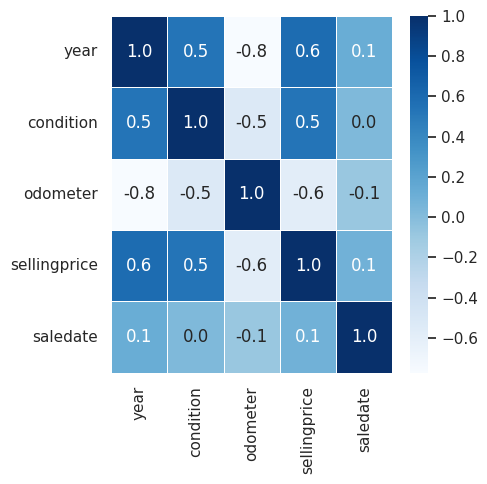

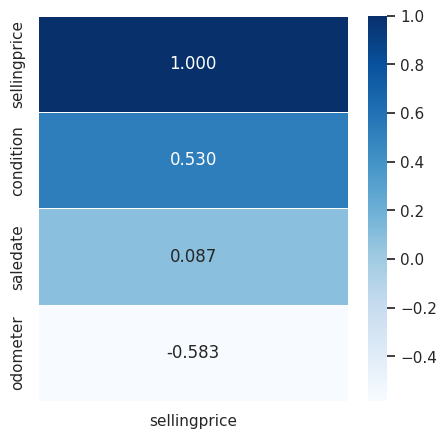

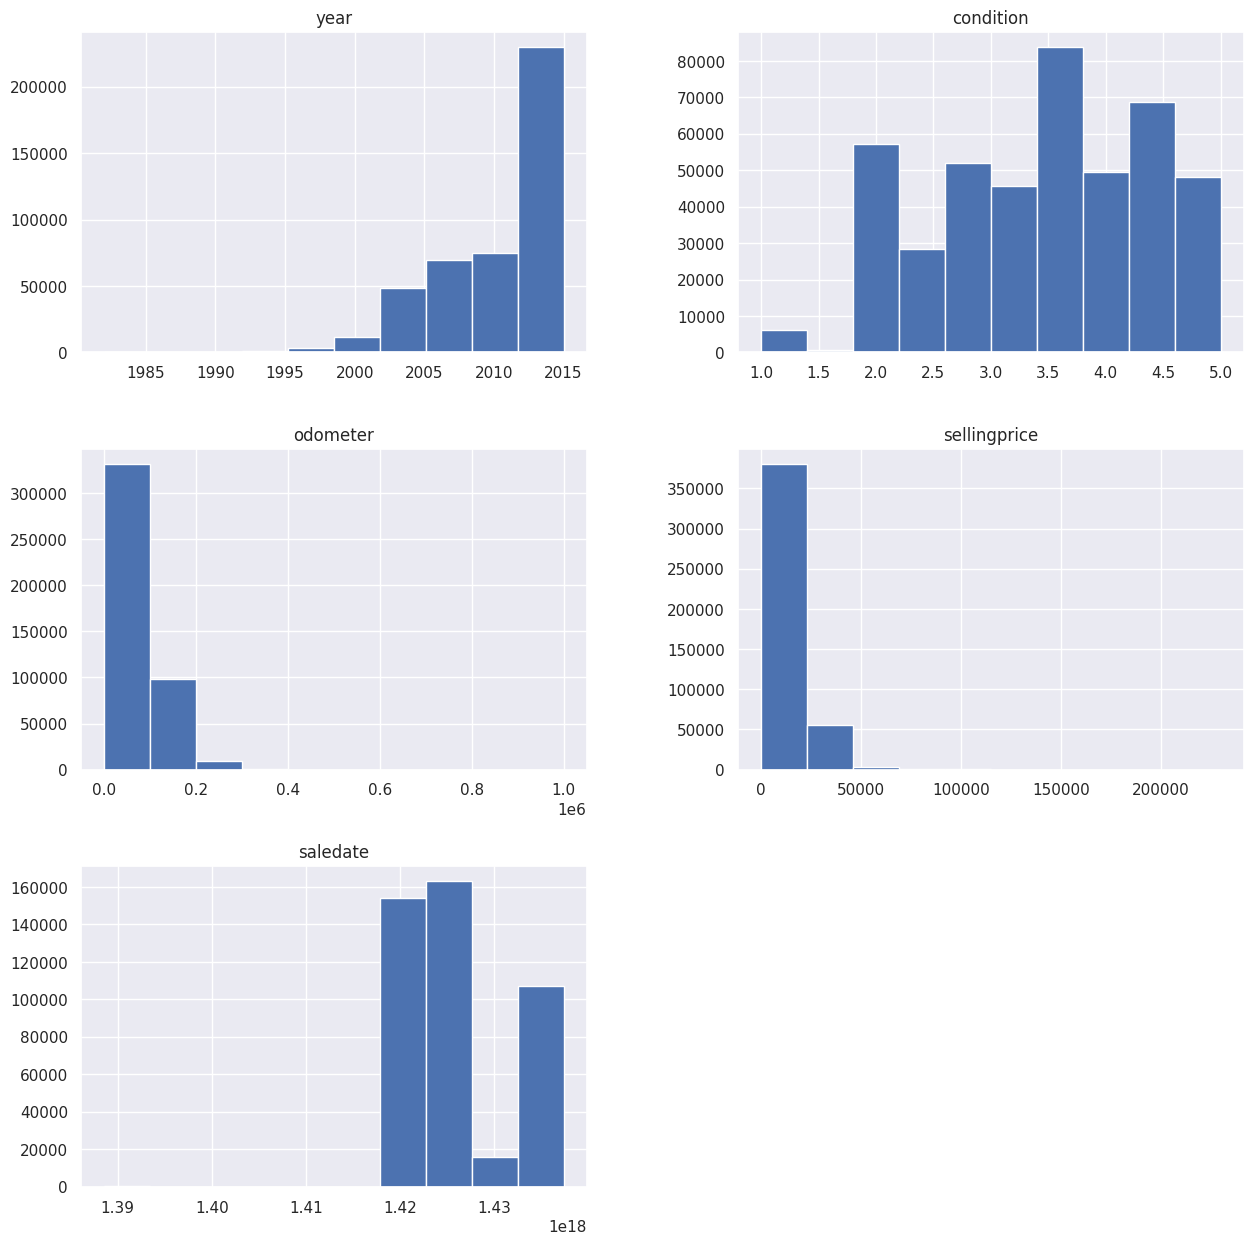

In [75]:
data_corr_describe(data_train)


Метод describe:


,year,condition,odometer,saledate
count,110060.000000,110060.000000,110060.000000,1.100600e+05
mean,2010.059904,3.427027,68072.904879,1.425588e+18
std,3.960432,0.941336,53519.352409,5.175109e+15
min,1982.000000,1.000000,1.000000,1.388539e+18
25%,2007.000000,2.700000,28317.000000,1.421777e+18
50%,2012.000000,3.600000,51922.000000,1.423762e+18
75%,2013.000000,4.200000,98847.250000,1.432170e+18
max,2015.000000,5.000000,999999.000000,1.436830e+18



Heatmap корреляции:



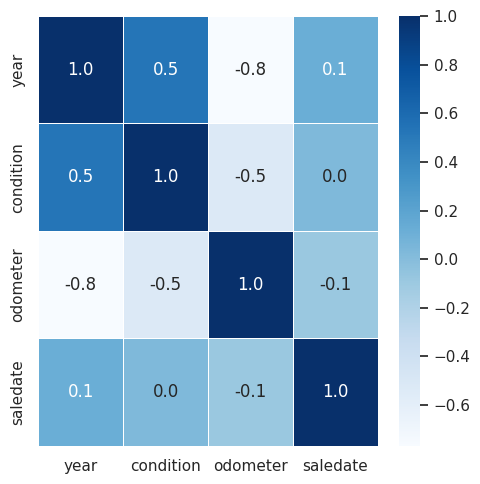

<Figure size 500x500 with 0 Axes>

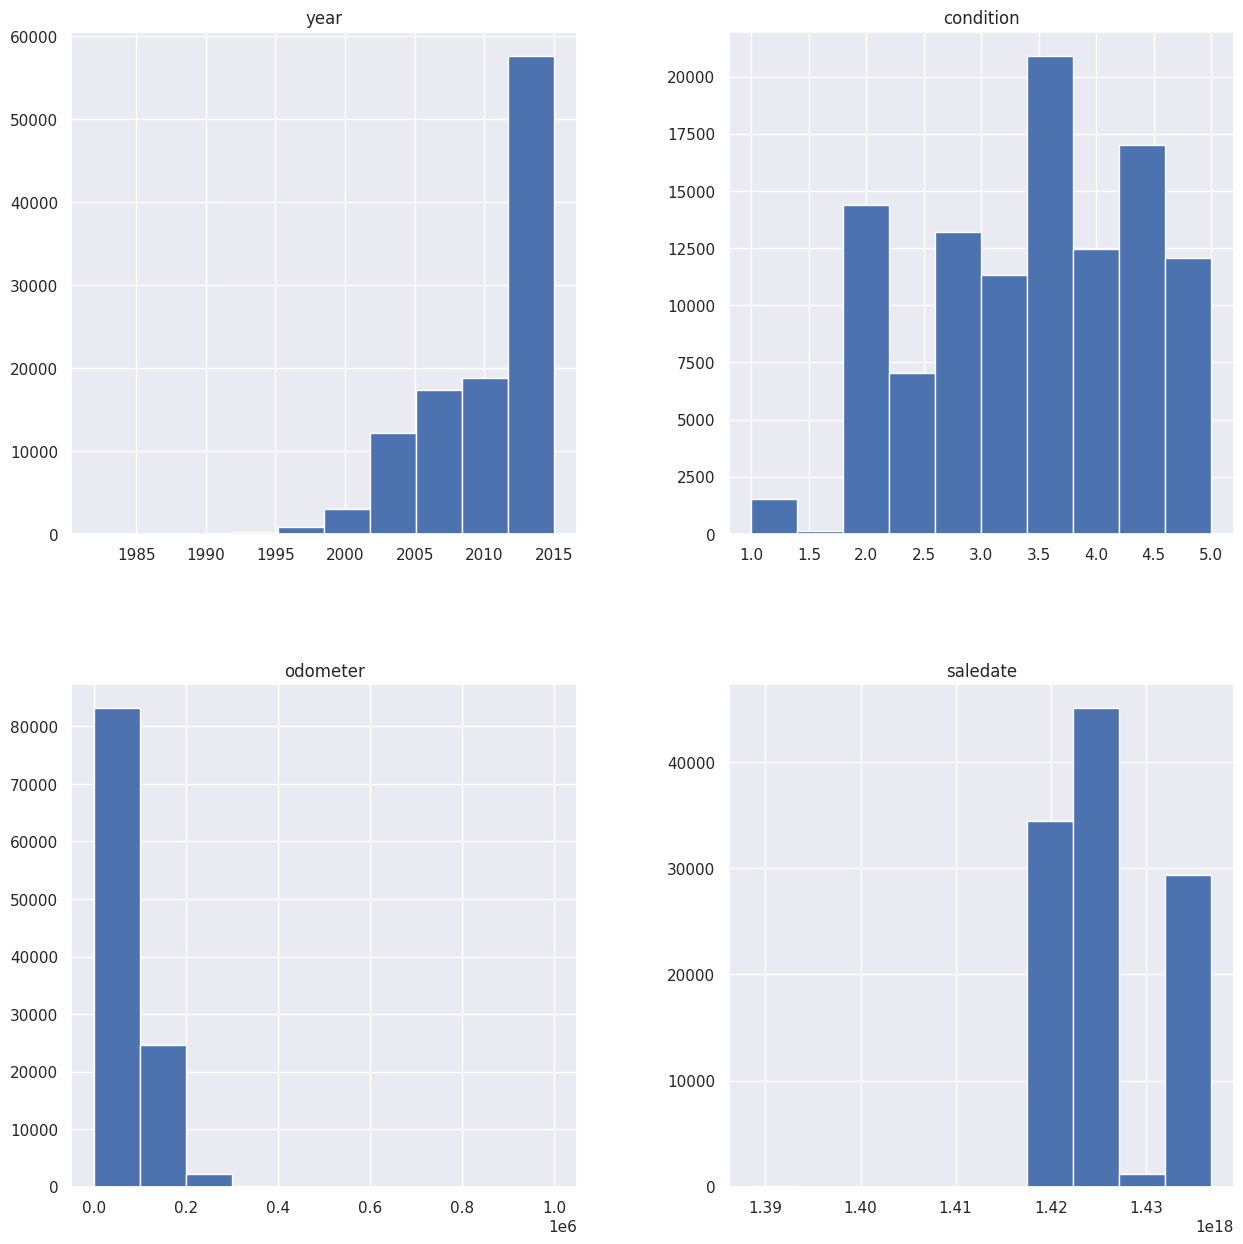

In [76]:
data_corr_describe(data_test)

In [77]:
data_train.corr()['sellingprice'].sort_values(ascending=False)[0:20] 

sellingprice    1.000000
year            0.586847
condition       0.529901
saledate        0.086846
odometer       -0.582933
Name: sellingprice, dtype: float64

Самая слабая корреляция у целевого признака с параметром 'saledate'. Тем не менее, оставим данный признак для обучения. Возможно, модель сможет увидеть скрытые зависимости.

Также мы видим отрицательную корреляцию с пробегом. Чем он выше, тем цена ниже. Это поддается логике.

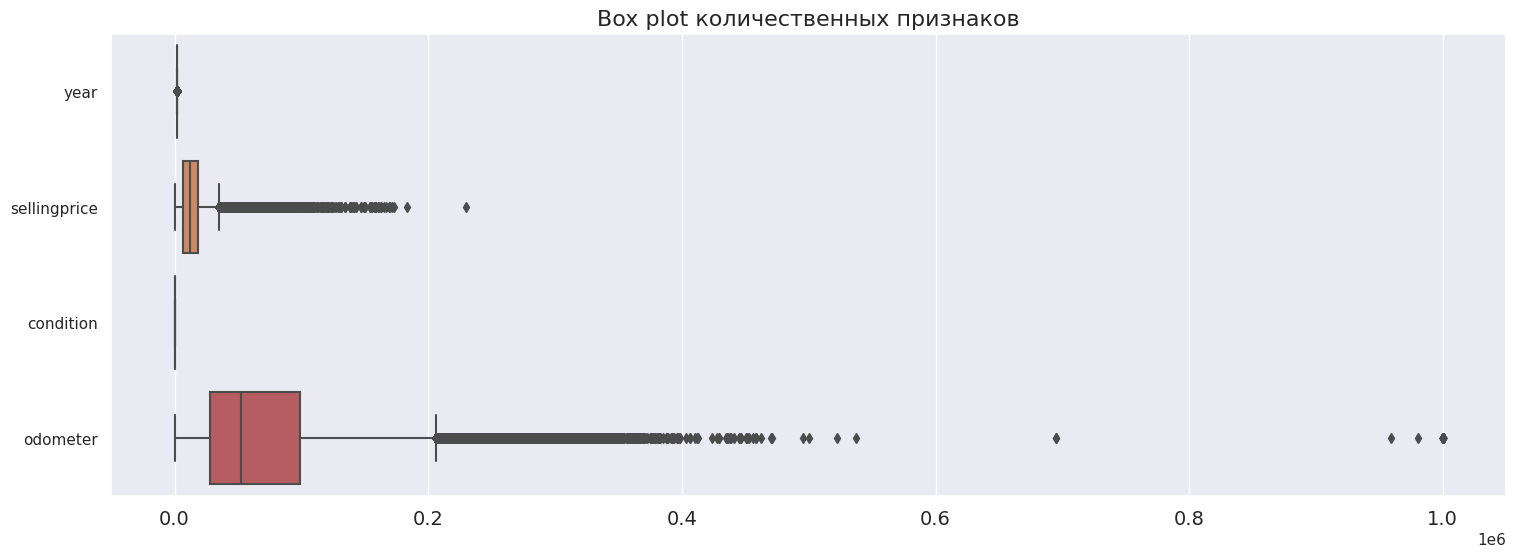

In [78]:
fig = plt.figure(figsize=(18,6))
sns.boxplot(data=data_train[numeric_columns], orient="h");
plt.xticks(fontsize=14)
plt.title('Box plot количественных признаков', fontsize=16);

Большое количество выбросов мы видим в целевом признаке и в показателях пробега. По цене - вполне объяснимо, так как могут быть и дорогие автомобили. По пробегу - видим явные выбросы в районе 1 млн. Посмотрим подробнее на эти данные.

In [79]:
data_train.loc[data_train['odometer'] == 999999]['odometer'].count()

55

Таких записей немного, и, тем не менее, обработаем их, заменив медианным значением. Скорее всего, такое значение могли поставить, когда не знали истинного значения пробега автомобиля,

In [80]:
data_train.loc[data_train['odometer'] == 999999, 'odometer'] = data_train['odometer'].median()

In [81]:
data_train.loc[data_train['odometer'] == 999999]['odometer'].count() #убедимся, что выбросы исчезли

0

#### Подготовка выборок для обучения

Для начала уберем из признаков колонку 'vin', которая полностью состоит из уникальных значений. Она бесполезна для модели. Также извлечем целевой признак из обучающей выборки.

Затем воспользуемся кодировкой категориальных признаков и отмасштабируем количественные.

In [82]:
features_train = data_train.drop(['sellingprice', 'vin'], axis=1) # извлечем основные признаки
target_train = data_train['sellingprice'] # извлечем целевой признак

display(features_train.shape)
target_train.shape

(440236, 13)

(440236,)

In [83]:
object_columns.remove('vin') #Уберем из списка категориальных признаков колонку 'vin' для дальнейшей работы

data_test_OE = data_test.drop(['vin'], axis=1) #подготовим тестовую для кодировки

encoder = ce.OrdinalEncoder(cols=object_columns)

features_train_OE = encoder.fit_transform(features_train)

data_test_OE = encoder.transform(data_test_OE)

display(features_train_OE.head())
data_test_OE.head()

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate
0,2011,1,1,1,1,1,1,4.2,111041.0,1,1,1,1
1,2014,1,2,2,2,1,2,3.5,31034.0,1,1,2,2
2,2012,2,3,3,2,1,3,2.2,35619.0,1,1,3,3
3,2003,3,4,4,1,1,4,2.8,131301.0,2,2,4,4
4,2007,1,2,1,2,1,1,2.0,127709.0,1,1,5,5


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,saledate
0,2005,11.0,19.0,4.0,2,1,9,2.7,116970.0,3,1,1549.0,271.0
1,2014,12.0,136.0,102.0,20,1,14,4.4,6286.0,5,3,96.0,153.0
2,2013,2.0,14.0,33.0,1,1,8,4.6,11831.0,6,1,3.0,75.0
3,2013,8.0,50.0,75.0,2,1,7,2.3,57105.0,3,1,1423.0,1585.0
4,2013,2.0,296.0,30.0,10,1,12,2.9,31083.0,1,1,282.0,105.0


In [84]:
#отмасштабируем количественные признаки
scaler = StandardScaler()
scaler.fit(features_train_OE.select_dtypes("number"))
features_train_scaled = scaler.transform(features_train_OE.select_dtypes("number"))
data_test_scaled = scaler.transform(data_test_OE.select_dtypes("number"))

features_train_scaled_df = pd.DataFrame(features_train_scaled, index=features_train_OE.index, columns=features_train_OE.columns)
data_test_scaled_df = pd.DataFrame(data_test_scaled, index=data_test_OE.index, columns=data_test_OE.columns)

#### Выбор модели для обучения

Поскольку задачей исследования является разработка модели по определению стоимости автомобиля, мы будем использовать модель регрессии, которая способна определить взаимосвязи в данных и предсказать стоимость с максимально возможной точностью. Наиболее оптимальным решением является применение модели с бустингом. Идея бустинга заключается в итеративном процессе последовательного построения частных моделей. Каждая новая модель обучается с использованием информации об ошибках, сделанных на предыдущем этапе, а результирующая функция представляет собой линейную комбинацию всего ансамбля моделей с учетом минимизации любой штрафной функции.

Таким образом, в проекте будет использоваться XGBRegressor и метрика оценки MAPE, которая показывает насколько точно модель предсказывает цену, процент отклонения модели от истины.

Для начала обучим базу и посмотрим, какое значение MAPE получится. Если оно нас не устроит, продолжим оптимизацию и воспользуемся optuna для поиска наилучших параметров модели.

In [85]:
#для удобства создадим функцию для подсчета метрики MAPE и сделаем кастомный скорер
def MAPE(y_true, y_pred): 
    return 100*(np.sum(np.abs(np.subtract(y_true,y_pred)))/np.sum(y_pred))

mape_scorer = make_scorer(MAPE)

In [86]:
model = XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=12345)
scores = cross_val_score(model, features_train_scaled_df, target_train, scoring=mape_scorer, cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAPE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAPE: 11.968 (0.111)


#### Отбор признаков для улучшения модели

In [87]:
model.fit(features_train_scaled_df, target_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Теперь посмотрим на важность признаков. Если мы увидим неважные признаки, попробуем убрать их при обучении модели, чтобы не перегружать процесс обучения.

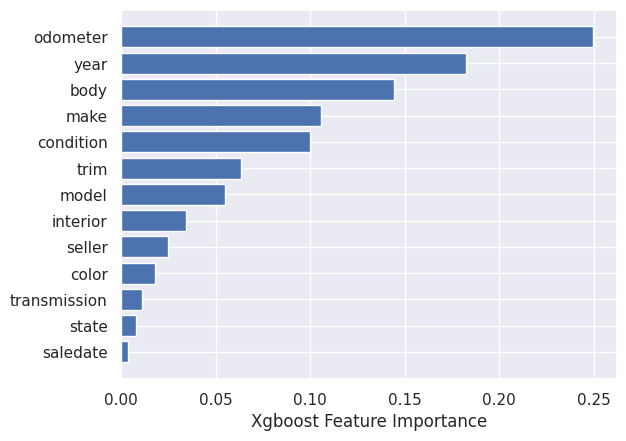

In [88]:
sorted_idx = model.feature_importances_.argsort()
plt.barh(features_train_scaled_df.columns[sorted_idx], model.feature_importances_[sorted_idx]);
plt.xlabel("Xgboost Feature Importance");

In [89]:
#отберем наиболее важные, чтобы затем обучить модель и посмотреть как изменится MAPE
features_train_selected = features_train_scaled_df.drop(['interior', 'seller', 'color', 'transmission', 'state', 'saledate'], axis=1)

In [90]:
model.fit(features_train_selected, target_train)
print(cross_val_score(model, features_train_selected, target_train, scoring=mape_scorer, cv=5).mean())

11.483962743713855


Метрика незначительно, но улучшилась. Попробуем подобрать гиперпараметры для наилучшего результата.

#### Подбор гиперпараметров модели

Для подбора гиперпараметров воспользуемся optuna. Это мощный и достаточно быстрый инструмент для поиска наиболее эффективных гиперпараметров для модели.

In [ ]:
def model_objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'random_state': trial.suggest_int('random_state', 1, 1000),
        'tree_method': trial.suggest_categorical('tree_method', {'gpu_hist', 'hist'}),
        'predictor': trial.suggest_categorical('predictor', {'auto', 'cpu_predictor', 'gpu_predictor'}),
        'booster': trial.suggest_categorical('booster', {'gbtree'})
    }

    model_1 = XGBRegressor(**param)

    model_1.fit(features_train_scaled_df, target_train)    
    mape = cross_val_score(model_1, features_train_scaled_df, target_train, scoring=mape_scorer, n_jobs=-1, cv=5).mean()
    
    return mape
    
#Вызовем optuna и установим гиперпараметры
model_study = optuna.create_study(direction='minimize')
model_study.optimize(model_objective, n_trials=60)

#Запомним лучшую модель с лучшими гиперпараметрами
best_model = XGBRegressor(**model_study.best_params)
trial = model_study.best_trial

#Для информации - визуализируем вклад каждого гиперпараметра в обучение модели
fig = optuna.visualization.plot_param_importances(model_study)
fig.show()

print("Лучшие гиперпараметры модели: {}".format(trial.params))
print("MAPE лучшей модели: {}".format(trial.value))

[I 2023-04-02 04:38:44,075] A new study created in memory with name: no-name-9fc7afe5-6ac6-4899-a385-190dc1c0a52e
[I 2023-04-02 04:40:30,864] Trial 0 finished with value: 10.320963668121843 and parameters: {'max_depth': 14, 'learning_rate': 0.24297838200134933, 'n_estimators': 706, 'min_child_weight': 8, 'gamma': 0.07976833410036807, 'subsample': 0.6184833174760652, 'colsample_bytree': 0.6168014799088356, 'reg_alpha': 0.9509542334672536, 'reg_lambda': 0.24900713142082387, 'random_state': 22, 'tree_method': 'hist', 'predictor': 'cpu_predictor', 'booster': 'gbtree'}. Best is trial 0 with value: 10.320963668121843.
[I 2023-04-02 04:40:57,014] Trial 1 finished with value: 13.844449202269303 and parameters: {'max_depth': 16, 'learning_rate': 0.3388854592693095, 'n_estimators': 114, 'min_child_weight': 2, 'gamma': 0.6228015485069474, 'subsample': 0.4334108044856979, 'colsample_bytree': 0.3095539857314509, 'reg_alpha': 0.74525348312883, 'reg_lambda': 0.961907512080848, 'random_state': 612, 't

Cохраним модель с самым лучшим результатом MAPE, который удалось достичь в процессе экспериментов - 8.06 на полной выборке, без уменьшения выборки после определения features importance. Как показали неоднократные попытки по уменьшению выборки, этот механизм не улучшает качество модели, а наоборот, даже немного ухудшает.

In [ ]:
param = {'max_depth': 14, 'learning_rate': 0.02848378680776663, 'n_estimators': 944, 'min_child_weight': 5, 'gamma': 0.9664189910790479, 'subsample': 0.7153380111541001, 'colsample_bytree': 0.944790050824031, 'reg_alpha': 0.1778208192084195, 'reg_lambda': 0.15544722186756976, 'random_state': 15, 'tree_method': 'gpu_hist', 'predictor': 'cpu_predictor', 'booster': 'gbtree'}
#param = {'max_depth': 10, 'learning_rate': 0.07754310023535682, 'n_estimators': 673, 'min_child_weight': 1, 'gamma': 0.20822850966521453, 'subsample': 0.7346414515941233, 'colsample_bytree': 0.8337303347995324, 'reg_alpha': 0.755054877808364, 'reg_lambda': 0.5876361475873725, 'random_state': 716, 'tree_method': 'gpu_hist', 'predictor': 'auto', 'booster': 'gbtree'}
best_model = XGBRegressor(**param)

#### Результаты работы модели

In [ ]:
best_model.fit(features_train_scaled_df, target_train)
#features_test_selected = data_test_scaled_df.drop(['interior', 'seller', 'color', 'transmission', 'state', 'saledate'], axis=1)
predictions = best_model.predict(data_test_scaled_df)

In [ ]:
#сохраним результат для подгрузки на kaggle
sample_submission = pd.concat([pd.DataFrame(data_test['vin']), pd.DataFrame(predictions)], axis=1)
sample_submission = sample_submission.rename(columns={0: 'sellingprice'})
sample_submission.to_csv('sample_submission_xgb_7.csv', index=False)

#### Общий вывод

Мы видим, что для предсказания цены автомобиля на вторичном рынке важны такие параметры как пробег, год выпуска авто, марка, тип кузова, а также состояние автомобиля. Для модели XGBRegressor данные признаки оказались наиболее существенными.

Такие признаки как салон автомобиля, его цвет, коробка передач, продавец авто, штат и дата продажи оказались второстепенными, что можно считать логичным.

Тем не менее, при попытке сократить обучающающую выборку, руководствуясь features_importance, результаты MAPE на тестовой выборке после подбора гиперпараметров не поднимались выше 15.7. На данный момент удалось добиться наилучшего результата по предсказанию стоимости автомобиля, и сейчас этот результат MAPE составляет 14,77 в таблице соревнования на kaggle.